# Transformers: Rise Of The Beasts #

[https://github.com/FedericoQuartieri/ANN](https://github.com/FedericoQuartieri/ANN/tree/preprocessing_gridsearch)

In [1]:
# OPTIMAL HYPERPARAMETERS - Based on empirical results

PATIENCE = 40
VERBOSE = 10

RNN_TYPE = 'GRU'
BIDIRECTIONAL = True
L1_LAMBDA = 0
LAMBDA_STD = 0
POWERFUL_GPU = True  # Use this macro to enable optimizations for powerful GPUs


# Reverse mapping from integers to pain level names
label_reverse_mapping = {
   0: 'no_pain',
   1: 'low_pain',
   2: 'high_pain'
}

# Create mapping dictionary for pain levels
pain_mapping = {
   'no_pain': 0,
   'low_pain': 1,
   'high_pain': 2
}

labels = ['no_pain', 'low_pain', 'high_pain']

num_classes = len(labels)

param_grid = {
   # Robust split
   'n_val_users':   [55],
   'k':             [5],
   'epochs':        [200],

   # CONTEXT
   'window_size':   [28],   
   'stride':        [4],    

   # ARCH
   'hidden_layers': [2],
   'hidden_size':   [256],

   # OPT / REGULARIZATION
   'batch_size':    [512],
   'learning_rate': [8e-4],
   'dropout_rate':  [0.5],        
   'l2_lambda':     [5e-4]
   # if needed:
   # 'rnn_type':     ['LSTM'],
   # 'bidirectional':[True],
}

In [2]:
import os, random, numpy as np

def physical_cores():
   try:
      import psutil
      n = psutil.cpu_count(logical=False)
      if n:
         return n
   except Exception:
      pass
   n = os.cpu_count() or 2
   return max(1, n // 2)  # Physics estimation if not available


SEED = 42
CONVERTIBLE = False

# Env BEFORE import torch
CORES = physical_cores()
OMP = max(1, CORES - 1)
os.environ.setdefault("OMP_NUM_THREADS", str(OMP))
os.environ.setdefault("MKL_NUM_THREADS", str(OMP))
os.environ.setdefault("MKL_DYNAMIC", "FALSE")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", str(OMP))
os.environ.setdefault("TORCH_NUM_INTEROP_THREADS", "1")
os.environ["PYTHONHASHSEED"] = str(SEED)

import torch
from torch import nn
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.set_num_threads(int(os.environ["OMP_NUM_THREADS"]))
try:
   torch.set_num_interop_threads(int(os.environ["TORCH_NUM_INTEROP_THREADS"]))
except RuntimeError as e:
   print("skip set_num_interop_threads:", e)


# Import necessary libraries
import os, subprocess, shlex

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)


# Device selection: prefer CUDA when available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.benchmark = True


print("DEBUG TORCH:")
print("  torch.__version__     =", torch.__version__)
print("  torch.version.cuda    =", torch.version.cuda)
print("  torch.cuda.is_available() =", torch.cuda.is_available())
print("  torch.cuda.device_count()  =", torch.cuda.device_count())
if torch.cuda.is_available():
    try:
      print("  GPU name:", torch.cuda.get_device_name(0))
    except Exception as e:
      print("  get_device_name error:", e)
print("  selected device =", device)


# From torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not CONVERTIBLE:

   # Configure plot display settings
   sns.set(font_scale=1.4)
   sns.set_style('white')
   plt.rc('font', size=14)
   %matplotlib inline

DEBUG TORCH:
  torch.__version__     = 2.9.0+cu128
  torch.version.cuda    = 12.8
  torch.cuda.is_available() = True
  torch.cuda.device_count()  = 1
  GPU name: NVIDIA GeForce RTX 4060 Laptop GPU
  selected device = cuda
PyTorch version: 2.9.0+cu128
Device: cuda


In [3]:
X_train = pd.read_csv('out/preprocessed_train.csv')
y_train = pd.read_csv('out/preprocessed_labels.csv')

# Merge with X_train based on sample_index
X_train = X_train.merge(
   y_train[['sample_index', 'label']],
   on='sample_index',
   how='left'
)

# Verify the mapping worked correctly
print("\nFirst few rows of X_train with encoded labels:")
print(X_train[['sample_index', 'label']].head(10))

print("\nLabel value counts:")
print(X_train['label'].value_counts())

print("\nCheck for NaN labels:")
print(f"NaN count: {X_train['label'].isna().sum()}")

input_shape = X_train.shape[1:]


First few rows of X_train with encoded labels:
   sample_index  label
0             0      0
1             0      0
2             0      0
3             0      0
4             0      0
5             0      0
6             0      0
7             0      0
8             0      0
9             0      0

Label value counts:
label
0    81760
1    15040
2     8960
Name: count, dtype: int64

Check for NaN labels:
NaN count: 0


In [4]:
# Drop joint_30 column (contains only NaN values)
print("Dropping joint_30 column (all NaN values)...")
for df in [X_train]:
    if 'joint_30' in df.columns:
      df.drop('joint_30', axis=1, inplace=True)
      print(f"Dropped joint_30 from {df.shape}")

print("\nColumns after dropping joint_30:")
print(f"X_train columns: {X_train.shape[1]}")

Dropping joint_30 column (all NaN values)...

Columns after dropping joint_30:
X_train columns: 74


In [5]:
print("\n--- Data structure ---")
print("\nX_train Info:")
X_train.info(verbose=True)
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print("\ny_train Info:")
y_train.info(verbose=True)
print(f"\nMissing values in y_train: {y_train.isnull().sum().sum()}")


--- Data structure ---

X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 74 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sample_index        105760 non-null  int64  
 1   time                105760 non-null  int64  
 2   pain_survey_1       105760 non-null  float64
 3   pain_survey_2       105760 non-null  float64
 4   pain_survey_3       105760 non-null  float64
 5   pain_survey_4       105760 non-null  float64
 6   joint_00            105760 non-null  float64
 7   joint_01            105760 non-null  float64
 8   joint_02            105760 non-null  float64
 9   joint_03            105760 non-null  float64
 10  joint_04            105760 non-null  float64
 11  joint_05            105760 non-null  float64
 12  joint_06            105760 non-null  float64
 13  joint_07            105760 non-null  float64
 14  joint_08            105760 non-null  float64


In [6]:
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21_ewm5,joint_22_ewm5,joint_23_ewm5,joint_24_ewm5,joint_25_ewm5,joint_26_ewm5,joint_27_ewm5,joint_28_ewm5,joint_29_ewm5,label
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,0.816873,0.827425,0.826820,0.831567,0.686204,0.700549,0.611301,0.619273,...,0.000085,0.000105,0.000335,0.001767,0.000329,0.071697,0.072486,0.077877,0.078966,0.311649
std,190.814948,46.187338,0.341212,0.334819,0.333324,0.330997,0.146848,0.150812,0.232164,0.244302,...,0.004860,0.006121,0.005798,0.017089,0.004885,0.092726,0.088618,0.084311,0.081389,0.619651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,165.000000,39.750000,1.000000,1.000000,1.000000,1.000000,0.602739,0.619990,0.445955,0.417875,...,0.000001,0.000002,0.000008,0.000039,0.000007,0.020744,0.018852,0.030129,0.028053,0.000000
50%,330.000000,79.500000,1.000000,1.000000,1.000000,1.000000,0.731352,0.748367,0.713774,0.738753,...,0.000003,0.000004,0.000013,0.000063,0.000013,0.040088,0.043089,0.053036,0.051489,0.000000
75%,495.000000,119.250000,1.000000,1.000000,1.000000,1.000000,0.786558,0.807224,0.780884,0.803154,...,0.000008,0.000009,0.000031,0.000137,0.000042,0.084708,0.092179,0.091413,0.105520,0.000000
max,660.000000,159.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [7]:
def build_sequences(df, window=200, stride=50):
   """
   Build sequences from time-series data

   Args:
      df: DataFrame with the data
      window: Window size for sequences
      stride: Stride for overlapping windows

   Returns:
      dataset: numpy array of sequences
      labels: numpy array of labels
   """
   # Initialise lists to store sequences and their corresponding labels
   dataset = []
   labels = []

   # Iterate over unique IDs in the DataFrame
   for sample_id in df['sample_index'].unique():
      # Extract sensor data for the current ID
      drop_cols = [c for c in ['sample_index', 'time', 'label', 'labels'] if c in df.columns]
      temp = df[df['sample_index'] == sample_id].drop(columns=drop_cols).values.astype('float32')

      # Retrieve the activity label for the current ID
      label_series = df[df['sample_index'] == sample_id]['label']

      # Check if label column exists and has values
      if label_series.empty:
         print(f"Warning: No label found for sample_id {sample_id}")
         continue

      label_value = label_series.values[0]

      # Skip samples with NaN labels
      if pd.isna(label_value):
         print(f"Warning: NaN label for sample_id {sample_id}, skipping...")
         continue

      # Convert to int and validate
      try:
         label = int(label_value)
         if label < 0 or label > 2:  # Assuming 3 classes: 0, 1, 2
               print(f"Warning: Invalid label {label} for sample_id {sample_id}, skipping...")
               continue
      except (ValueError, TypeError) as e:
         print(f"Warning: Cannot convert label {label_value} to int for sample_id {sample_id}: {e}")
         continue


      # --- NEW: no padding for window multiples ---
      L = len(temp)

      # Padding ONLY if L < window (so at least 1 window)
      if L < window:
         pad = window - L
         temp = np.concatenate([temp, np.zeros((pad, temp.shape[1]), dtype='float32')], axis=0)
         L = len(temp)  # Now L == window

      # Generate the start indices using the stride, WITHOUT expanding to multiples of the window.
      starts = list(range(0, max(L - window, 0) + 1, stride))

      # (Optional) Anchor last window at the end if not aligned
      last_start = L - window
      if last_start >= 0 and (len(starts) == 0 or starts[-1] != last_start):
         starts.append(last_start)

      for s in starts:
         dataset.append(temp[s:s+window])
         labels.append(label)

   # Convert lists to numpy arrays for further processing
   dataset = np.array(dataset, dtype='float32')
   labels = np.array(labels, dtype='int64')

   print(f"Built {len(dataset)} sequences with {len(labels)} labels")

   return dataset, labels

In [8]:
def make_loader(ds, batch_size, shuffle, drop_last):
   if ( POWERFUL_GPU):
      cpu_cores = os.cpu_count() or 2
      num_workers = max(4, min(8, cpu_cores))

      # Create DataLoader with performance optimizations
      return DataLoader(
         ds,
         batch_size=batch_size,
         shuffle=shuffle,
         drop_last=drop_last,
         num_workers=num_workers,
         pin_memory=True,  # Faster GPU transfer
         pin_memory_device="cuda" if torch.cuda.is_available() else "",
         prefetch_factor=8,  # Load 4 batches ahead
         persistent_workers= True if num_workers > 0 else False,
      )
      # Standard DataLoader without optimizations
   else :
      # Determine optimal number of worker processes for data loading
      cpu_cores = os.cpu_count() or 2
      num_workers = max(2, min(4, cpu_cores))

      # Create DataLoader with performance optimizations
      return DataLoader(
         ds,
         batch_size=batch_size,
         shuffle=shuffle,
         drop_last=drop_last,
         num_workers=num_workers,
         pin_memory=True,  # Faster GPU transfer
         pin_memory_device="cuda" if torch.cuda.is_available() else "",
         prefetch_factor=4,  # Load 4 batches ahead
      )

In [9]:
def recurrent_summary(model, input_size):
   """
   Custom summary function that emulates torchinfo's output while correctly
   counting parameters for RNN/GRU/LSTM layers.

   This function is designed for models whose direct children are
   nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

   Args:
      model (nn.Module): The model to analyze.
      input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
   """

   # Dictionary to store output shapes captured by forward hooks
   output_shapes = {}
   # List to track hook handles for later removal
   hooks = []

   def get_hook(name):
      """Factory function to create a forward hook for a specific module."""
      def hook(module, input, output):
         # Handle RNN layer outputs (returns a tuple)
         if isinstance(output, tuple):
               # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
               shape1 = list(output[0].shape)
               shape1[0] = -1  # Replace batch dimension with -1

               # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
               if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                  shape2 = list(output[1][0].shape)  # Extract h_n only
               else:  # RNN/GRU case: h_n only
                  shape2 = list(output[1].shape)

               # Replace batch dimension (middle position) with -1
               shape2[1] = -1

               output_shapes[name] = f"[{shape1}, {shape2}]"

         # Handle standard layer outputs (e.g., Linear)
         else:
               shape = list(output.shape)
               shape[0] = -1  # Replace batch dimension with -1
               output_shapes[name] = f"{shape}"
      return hook

   # 1. Determine the device where model parameters reside
   try:
      device = next(model.parameters()).device
   except StopIteration:
      device = torch.device("cpu")  # Fallback for models without parameters

   # 2. Create a dummy input tensor with batch_size=1
   dummy_input = torch.randn(1, *input_size).to(device)

   # 3. Register forward hooks on target layers
   # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
   for name, module in model.named_children():
      if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
         # Register the hook and store its handle for cleanup
         hook_handle = module.register_forward_hook(get_hook(name))
         hooks.append(hook_handle)

   # 4. Execute a dummy forward pass in evaluation mode
   model.eval()
   with torch.no_grad():
      try:
         model(dummy_input)
      except Exception as e:
         print(f"Error during dummy forward pass: {e}")
         # Clean up hooks even if an error occurs
         for h in hooks:
               h.remove()
         return

   # 5. Remove all registered hooks
   for h in hooks:
      h.remove()

   # --- 6. Print the summary table ---

   print("-" * 79)
   # Column headers
   print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
   print("=" * 79)

   total_params = 0
   total_trainable_params = 0

   # Iterate through modules again to collect and display parameter information
   for name, module in model.named_children():
      if name in output_shapes:
         # Count total and trainable parameters for this module
         module_params = sum(p.numel() for p in module.parameters())
         trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

         total_params += module_params
         total_trainable_params += trainable_params

         # Format strings for display
         layer_name = f"{name} ({type(module).__name__})"
         output_shape_str = str(output_shapes[name])
         params_str = f"{trainable_params:,}"

         print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

   print("=" * 79)
   print(f"Total params: {total_params:,}")
   print(f"Trainable params: {total_trainable_params:,}")
   print(f"Non-trainable params: {total_params - total_trainable_params:,}")
   print("-" * 79)

In [10]:
class RecurrentClassifier(nn.Module):
   """
   Generic RNN classifier (RNN, LSTM, GRU).
   Uses the last hidden state for classification.
   """
   def __init__(
         self,
         input_size,
         hidden_size,
         num_layers,
         num_classes,
         rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
         bidirectional=False,
         dropout_rate=0.2
         ):
      super().__init__()

      self.rnn_type = rnn_type
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.bidirectional = bidirectional

      # Map string name to PyTorch RNN class
      rnn_map = {
         'RNN': nn.RNN,
         'LSTM': nn.LSTM,
         'GRU': nn.GRU
      }

      if rnn_type not in rnn_map:
         raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

      rnn_module = rnn_map[rnn_type]

      # Dropout is only applied between layers (if num_layers > 1)
      dropout_val = dropout_rate if num_layers > 1 else 0

      # Create the recurrent layer
      self.rnn = rnn_module(
         input_size=input_size,
         hidden_size=hidden_size,
         num_layers=num_layers,
         batch_first=True,       # Input shape: (batch, seq_len, features)
         bidirectional=bidirectional,
         dropout=dropout_val
      )

      # Calculate input size for the final classifier
      if self.bidirectional:
         classifier_input_size = hidden_size * 2 # Concat fwd + bwd
      else:
         classifier_input_size = hidden_size

      # Final classification layer
      self.classifier = nn.Linear(classifier_input_size, num_classes)

   def forward(self, x):
      """
      x shape: (batch_size, seq_length, input_size)
      """

      # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
      rnn_out, hidden = self.rnn(x)

      # LSTM returns (h_n, c_n), we only need h_n
      if self.rnn_type == 'LSTM':
         hidden = hidden[0]
      # Hidden shape: (num_layers * num_directions, batch_size, hidden_size)

      if self.bidirectional:
         # Reshape to (num_layers, 2, batch_size, hidden_size)
         hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

         # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
         # Final shape: (batch_size, hidden_size * 2)
         hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
      else:
         # Take the last layer's hidden state
         # Final shape: (batch_size, hidden_size)
         hidden_to_classify = hidden[-1]

      # Get logits
      logits = self.classifier(hidden_to_classify)
      return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
   input_size=input_shape[-1], # Pass the number of features
   hidden_size=128,
   num_layers=2,
   num_classes=num_classes,
   dropout_rate=0.,
   rnn_type='RNN'
   ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 128], [2, -1]]         59,136         
classifier (Linear)       [-1]                         387            
Total params: 59,523
Trainable params: 59,523
Non-trainable params: 0
-------------------------------------------------------------------------------


In [11]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
   """
   Perform one complete training epoch through the entire training dataset.

   Args:
      model (nn.Module): The neural network model to train
      train_loader (DataLoader): PyTorch DataLoader containing training data batches
      criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
      optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
      scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
      device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
      l1_lambda (float): Lambda for L1 regularization
      l2_lambda (float): Lambda for L2 regularization

   Returns:
      tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
   """
   model.train()  # Set model to training mode

   running_loss = 0.0
   all_predictions = []
   all_targets = []

   # Iterate through training batches
   for batch_idx, (inputs, targets) in enumerate(train_loader):
      # Move data to device (GPU/CPU)
      inputs, targets = inputs.to(device), targets.to(device)

      # Clear gradients from previous step
      optimizer.zero_grad(set_to_none=True)

      # Forward pass with mixed precision (if CUDA available)
      with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
         logits = model(inputs)
         loss = criterion(logits, targets)

         # Add L1 and L2 regularization
         l1_norm = sum(p.abs().sum() for p in model.parameters())
         l2_norm = sum(p.pow(2).sum() for p in model.parameters())
         loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


      # Backward pass with gradient scaling
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # Accumulate metrics
      running_loss += loss.item() * inputs.size(0)
      predictions = logits.argmax(dim=1)
      all_predictions.append(predictions.cpu().numpy())
      all_targets.append(targets.cpu().numpy())

   # Calculate epoch metrics
   epoch_loss = running_loss / len(train_loader.dataset)
   epoch_f1 = f1_score(
      np.concatenate(all_targets),
      np.concatenate(all_predictions),
      average='weighted'
   )

   return epoch_loss, epoch_f1

In [13]:
def validate_one_epoch(model, val_loader, criterion, device):
   """
   Perform one complete validation epoch through the entire validation dataset.

   Args:
      model (nn.Module): The neural network model to evaluate (must be in eval mode)
      val_loader (DataLoader): PyTorch DataLoader containing validation data batches
      criterion (nn.Module): Loss function used to calculate validation loss
      device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

   Returns:
      tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

   Note:
      This function automatically sets the model to evaluation mode and disables
      gradient computation for efficiency during validation.
   """
   model.eval()  # Set model to evaluation mode

   running_loss = 0.0
   all_predictions = []
   all_targets = []

   # Disable gradient computation for validation
   with torch.no_grad():
      for inputs, targets in val_loader:
         # Move data to device
         inputs, targets = inputs.to(device), targets.to(device)

         # Forward pass with mixed precision (if CUDA available)
         with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
               logits = model(inputs)
               loss = criterion(logits, targets)

         # Accumulate metrics
         running_loss += loss.item() * inputs.size(0)
         predictions = logits.argmax(dim=1)
         all_predictions.append(predictions.cpu().numpy())
         all_targets.append(targets.cpu().numpy())

   # Calculate epoch metrics
   epoch_loss = running_loss / len(val_loader.dataset)
   epoch_accuracy = f1_score(
      np.concatenate(all_targets),
      np.concatenate(all_predictions),
      average='weighted'
   )

   return epoch_loss, epoch_accuracy

In [14]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
   """
   Log training metrics and model parameters to TensorBoard for visualization.

   Args:
      writer (SummaryWriter): TensorBoard SummaryWriter object for logging
      epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
      train_loss (float): Training loss for this epoch
      train_f1 (float): Training f1 score for this epoch
      val_loss (float): Validation loss for this epoch
      val_f1 (float): Validation f1 score for this epoch
      model (nn.Module): The neural network model (for logging weights/gradients)

   Note:
      This function logs scalar metrics (loss/f1 score) and histograms of model
      parameters and gradients, which helps monitor training progress and detect
      issues like vanishing/exploding gradients.
   """
   # Log scalar metrics
   writer.add_scalar('Loss/Training', train_loss, epoch)
   writer.add_scalar('Loss/Validation', val_loss, epoch)
   writer.add_scalar('F1/Training', train_f1, epoch)
   writer.add_scalar('F1/Validation', val_f1, epoch)

   # Log model parameters and gradients
   for name, param in model.named_parameters():
      if param.requires_grad:
         # Check if the tensor is not empty before adding a histogram
         if param.numel() > 0:
               writer.add_histogram(f'{name}/weights', param.data, epoch)
         if param.grad is not None:
               # Check if the gradient tensor is not empty before adding a histogram
               if param.grad.numel() > 0:
                  if param.grad is not None and torch.isfinite(param.grad).all():
                     writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [15]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
   """
   Train the neural network model on the training data and validate on the validation data.

   Args:
      model (nn.Module): The neural network model to train
      train_loader (DataLoader): PyTorch DataLoader containing training data batches
      val_loader (DataLoader): PyTorch DataLoader containing validation data batches
      epochs (int): Number of training epochs
      criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
      optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
      scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
      device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
      l1_lambda (float): L1 regularization coefficient (default: 0)
      l2_lambda (float): L2 regularization coefficient (default: 0)
      patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
      evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
      mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
      restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
      writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
      verbose (int, optional): Frequency of printing training progress (default: 10)
      experiment_name (str, optional): Experiment name for saving models (default: "")

   Returns:
      tuple: (model, training_history) - Trained model and metrics history
   """

   # Initialize metrics tracking
   training_history = {
      'train_loss': [], 'val_loss': [],
      'train_f1': [], 'val_f1': []
   }

   # Configure early stopping if patience is set
   if patience > 0:
      patience_counter = 0
      best_metric = float('-inf') if mode == 'max' else float('inf')
      best_epoch = 0

   print(f"Training {epochs} epochs...")

   # Main training loop: iterate through epochs
   for epoch in range(1, epochs + 1):

      # Forward pass through training data, compute gradients, update weights
      train_loss, train_f1 = train_one_epoch(
         model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
      )

      # Evaluate model on validation data without updating weights
      val_loss, val_f1 = validate_one_epoch(
         model, val_loader, criterion, device
      )

      # Store metrics for plotting and analysis
      training_history['train_loss'].append(train_loss)
      training_history['val_loss'].append(val_loss)
      training_history['train_f1'].append(train_f1)
      training_history['val_f1'].append(val_f1)

      # Write metrics to TensorBoard for visualization
      if writer is not None:
         log_metrics_to_tensorboard(
               writer, epoch, train_loss, train_f1, val_loss, val_f1, model
         )

      # Print progress every N epochs or on first epoch
      if verbose > 0:
         if epoch % verbose == 0 or epoch == 1:
               print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

      # Early stopping logic: monitor metric and save best model
      if patience > 0:
         current_metric = training_history[evaluation_metric][-1]
         is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

         if is_improvement:
               best_metric = current_metric
               best_epoch = epoch
               torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
               patience_counter = 0
         else:
               patience_counter += 1
               if patience_counter >= patience:
                  print(f"Early stopping triggered after {epoch} epochs.")
                  break

   # Restore best model weights if early stopping was used
   if restore_best_weights and patience > 0:
      model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
      print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

   # Save final model if no early stopping
   if patience == 0:
      torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

   # Close TensorBoard writer
   if writer is not None:
      writer.close()

   return model, training_history

# KFOLD

In [16]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
   """
   Perform K-fold shuffle split cross-validation with sample-based splitting for Pirate Pain time series data.

   Args:
      df: DataFrame with columns ['sample_index', 'time', 'label', 'pain_survey_*', 'joint_*', 'n_legs', 'n_hands', 'n_eyes']
      epochs: Number of training epochs
      criterion: Loss function
      device: torch.device for computation
      k: Number of cross-validation splits
      n_val_users: Number of samples for validation set
      n_test_users: Number of samples for test set
      batch_size: Batch size for training
      hidden_layers: Number of recurrent layers
      hidden_size: Hidden state dimensionality
      learning_rate: Learning rate for optimizer
      dropout_rate: Dropout rate
      window_size: Length of sliding windows
      stride: Step size for sliding windows
      rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
      bidirectional: Whether to use bidirectional RNN
      l1_lambda: L1 regularization coefficient (if used)
      l2_lambda: L2 regularization coefficient (weight_decay)
      patience: Early stopping patience
      evaluation_metric: Metric to monitor for early stopping
      mode: 'max' or 'min' for evaluation metric
      restore_best_weights: Whether to restore best weights after training
      writer: TensorBoard writer
      verbose: Verbosity level
      seed: Random seed
      experiment_name: Name for experiment logging

   Returns:
      fold_losses: Dict with validation losses for each split
      fold_metrics: Dict with validation F1 scores for each split
      best_scores: Dict with best F1 score for each split plus mean and std
   """

   # Initialise containers for results across all splits
   fold_losses = {}
   fold_metrics = {}
   best_scores = {}


   # Define columns to normalize
   # Define columns to normalize (all columns except sample_index, time, and label)
   exclude_columns = ['sample_index', 'time', 'label']
   scale_columns = [col for col in df.columns if col not in exclude_columns]

   # Get model architecture parameters
   # Count features (excluding sample_index, time, label)
   feature_cols = scale_columns  # All features that will be used
   in_features = len(feature_cols)
   num_classes = 3  # no_pain, low_pain, high_pain

   # Initialise model architecture
   model = RecurrentClassifier(
      input_size=in_features,
      hidden_size=hidden_size,
      num_layers=hidden_layers,
      num_classes=num_classes,
      dropout_rate=dropout_rate,
      bidirectional=bidirectional,
      rnn_type=rnn_type
   ).to(device)

   # Store initial weights to reset model for each split
   initial_state = copy.deepcopy(model.state_dict())

   # Iterate through K random splits
   for split_idx in range(k):

      if verbose > 0:
         print(f"Split {split_idx+1}/{k}")

      # Get unique sample IDs and shuffle them with split-specific seed
      unique_samples = df['sample_index'].unique()
      random.seed(seed + split_idx)
      random.shuffle(unique_samples)

      # Calculate the number of samples for the training set
      n_train_samples = len(unique_samples) - n_val_users

      # Split the shuffled sample IDs into training, validation, and test sets
      train_samples = unique_samples[:n_train_samples]
      val_samples = unique_samples[n_train_samples:n_train_samples + n_val_users]

      # Split the dataset into training, validation, and test sets based on sample IDs
      df_train = df[df['sample_index'].isin(train_samples)].copy()
      df_val = df[df['sample_index'].isin(val_samples)].copy()

      if verbose > 0:
         print(f"  Training set shape: {df_train.shape}")
         print(f"  Validation set shape: {df_val.shape}")

      # Map pain labels to integers (if not already mapped)
      if df_train['label'].dtype == 'object':
         df_train['label'] = df_train['label'].map(pain_mapping)
         df_val['label'] = df_val['label'].map(pain_mapping)



      # Build sequences using the existing build_sequences function
      X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
      X_val, y_val = build_sequences(df_val, window=window_size, stride=stride)

      if verbose > 0:
         print(f"  Training sequences shape: {X_train.shape}")
         print(f"  Validation sequences shape: {X_val.shape}")

      # Calculate class weights to handle imbalance
      class_counts = np.bincount(y_train)
      total_samples = len(y_train)
      class_weights = total_samples / (num_classes * class_counts)
      class_weights_tensor = torch.FloatTensor(class_weights).to(device)
      
      if verbose > 0:
         print(f"  Class distribution in training: {class_counts}")
         print(f"  Class weights: {class_weights}")

      # Create weighted loss function for this split
      criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_tensor)

      # Create PyTorch datasets
      train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
      val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

      # Create data loaders
      train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
      val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

      # Reset model to initial weights for fair comparison across splits
      model.load_state_dict(initial_state)

      # Define optimizer with L2 regularization
      optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

      # Enable mixed precision training for GPU acceleration
      split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

      # Create directory for model checkpoints
      os.makedirs(f"models/{experiment_name}", exist_ok=True)

      # Train model on current split with weighted loss
      model, training_history = fit(
         model=model,
         train_loader=train_loader,
         val_loader=val_loader,
         epochs=epochs,
         criterion=criterion_weighted,  # Use weighted criterion
         optimizer=optimizer,
         scaler=split_scaler,
         device=device,
         writer=writer,
         patience=patience,
         verbose=verbose,
         l1_lambda=l1_lambda,
         evaluation_metric=evaluation_metric,
         mode=mode,
         restore_best_weights=restore_best_weights,
         experiment_name=experiment_name+"/split_"+str(split_idx)
      )

      # Store results for this split
      fold_losses[f"split_{split_idx}"] = training_history['val_loss']
      fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
      best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

   # Compute mean and standard deviation of best scores across splits
   best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
   best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

   if verbose > 0:
      print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

   return fold_losses, fold_metrics, best_scores


In [17]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
   """
   Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

   Args:
      df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
      param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
      fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
      cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
      verbose: Print progress for each configuration

   Returns:
      results: Dict with scores for each configuration
      best_config: Dict with best hyperparameter combination
      best_score: Best mean F1 score achieved
   """
   # Generate all parameter combinations
   param_names = list(param_grid.keys())
   param_values = list(param_grid.values())
   combinations = list(product(*param_values))

   results = {}
   best_score = -np.inf
   best_config = None

   total = len(combinations)

   for idx, combo in enumerate(combinations, 1):
      # Create current configuration dict
      current_config = dict(zip(param_names, combo))
      config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

      if verbose:
         print(f"\nConfiguration {idx}/{total}:")
         for param, value in current_config.items():
               print(f"  {param}: {value}")

      # Merge current config with fixed parameters
      run_params = {**fixed_params, **current_config}

      # Execute cross-validation
      _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
         df=df,
         experiment_name=config_str,
         **run_params,
         **cv_params
      )

      # Store results
      results[config_str] = fold_scores

      current_score = fold_scores["mean"] - LAMBDA_STD * fold_scores["std"]
      fold_scores["mean_minus_lambda_std"] = current_score

      # Track best configuration using mean - std
      if current_score > best_score:
         best_score = current_score
         best_config = current_config.copy()
         if verbose:
               print(f"  NEW BEST SCORE! (mean - std = {current_score:.4f})")

      if verbose:
         print(
               f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f} "
               f"(mean - std = {current_score:.4f})"
         )

   return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
   """
   Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

   Args:
      results: Dict of results from grid_search_cv_rnn
      k_splits: Number of CV splits used
      top_n: Number of top configurations to display
      figsize: Figure size tuple
   """
   # Sort by mean score
   config_scores = {name: data['mean'] for name, data in results.items()}
   sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

   # Select top N
   top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

   # Prepare boxplot data
   boxplot_data = []
   labels = []

   # Define a dictionary for replacements, ordered to handle prefixes correctly
   replacements = {
      'batch_size_': 'BS=',
      'learning_rate_': '\nLR=',
      'hidden_layers_': '\nHL=',
      'hidden_size_': '\nHS=',
      'dropout_rate_': '\nDR=',
      'window_size_': '\nWS=',
      'stride_': '\nSTR=',
      'rnn_type_': '\nRNN=',
      'bidirectional_': '\nBIDIR=',
      'l1_lambda_': '\nL1=',
      'l2_lambda_': '\nL2='
   }

   # Replacements for separators
   separator_replacements = {
      '_learning_rate_': '\nLR=',
      '_hidden_layers_': '\nHL=',
      '_hidden_size_': '\nHS=',
      '_dropout_rate_': '\nDR=',
      '_window_size_': '\nWS=',
      '_stride_': '\nSTR=',
      '_rnn_type_': '\nRNN=',
      '_bidirectional_': '\nBIDIR=',
      '_l1_lambda_': '\nL1=',
      '_l2_lambda_': '\nL2=',
      '_': ''
   }

   for config_name, mean_score in top_configs:
      # Extract best score from each split (auto-detect number of splits)
      split_scores = []
      for i in range(k_splits):
         if f'split_{i}' in results[config_name]:
               split_scores.append(results[config_name][f'split_{i}'])
      boxplot_data.append(split_scores)

      # Verify we have the expected number of splits
      if len(split_scores) != k_splits:
         print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

      # Create readable label using the replacements dictionary
      readable_label = config_name
      for old, new in replacements.items():
         readable_label = readable_label.replace(old, new)

      # Apply separator replacements
      for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)

      labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

   # Create plot
   fig, ax = plt.subplots(figsize=figsize)
   bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                  showmeans=True, meanline=True)

   # Styling
   for patch in bp['boxes']:
      patch.set_facecolor('lightblue')
      patch.set_alpha(0.7)

   # Highlight best configuration
   ax.get_xticklabels()[0].set_fontweight('bold')

   ax.set_ylabel('F1 Score')
   ax.set_xlabel('Configuration')
   ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
   ax.grid(alpha=0.3, axis='y')

   plt.xticks(rotation=0, ha='center')
   plt.tight_layout()
   plt.show()

In [18]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [19]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def timing(label="Block"):
   t0 = perf_counter()
   try:
      yield
   finally:
      print(f"{label} took {perf_counter() - t0:.2f}s")

with timing("Grid search"):
   fixed_params = {
      'l1_lambda': L1_LAMBDA,
      'rnn_type': RNN_TYPE,
      'bidirectional': BIDIRECTIONAL,
   }
   cv_params = {
      'criterion': criterion,
      'device': device,
      'patience': PATIENCE,
      'verbose': 0,
      'seed': SEED,
      'evaluation_metric': 'val_f1',
      'mode': 'max',
      'restore_best_weights': True,
      'writer': None,
   }
   results, best_config, best_score = grid_search_cv_rnn(
      df=X_train,
      param_grid=param_grid,
      fixed_params=fixed_params,
      cv_params=cv_params,
   )


Configuration 1/1:
  n_val_users: 55
  k: 5
  epochs: 200
  window_size: 28
  stride: 4
  hidden_layers: 2
  hidden_size: 256
  batch_size: 512
  learning_rate: 0.0008
  dropout_rate: 0.5
  l2_lambda: 0.0005
Built 20604 sequences with 20604 labels
Built 1870 sequences with 1870 labels
Training 200 epochs...
Early stopping triggered after 65 epochs.
Best model restored from epoch 25 with val_f1 0.9570
Built 20604 sequences with 20604 labels
Built 1870 sequences with 1870 labels
Training 200 epochs...
Early stopping triggered after 110 epochs.
Best model restored from epoch 70 with val_f1 0.9044
Built 20604 sequences with 20604 labels
Built 1870 sequences with 1870 labels
Training 200 epochs...
Early stopping triggered after 95 epochs.
Best model restored from epoch 55 with val_f1 0.9063
Built 20604 sequences with 20604 labels
Built 1870 sequences with 1870 labels
Training 200 epochs...
Early stopping triggered after 62 epochs.
Best model restored from epoch 22 with val_f1 0.9699
Built 

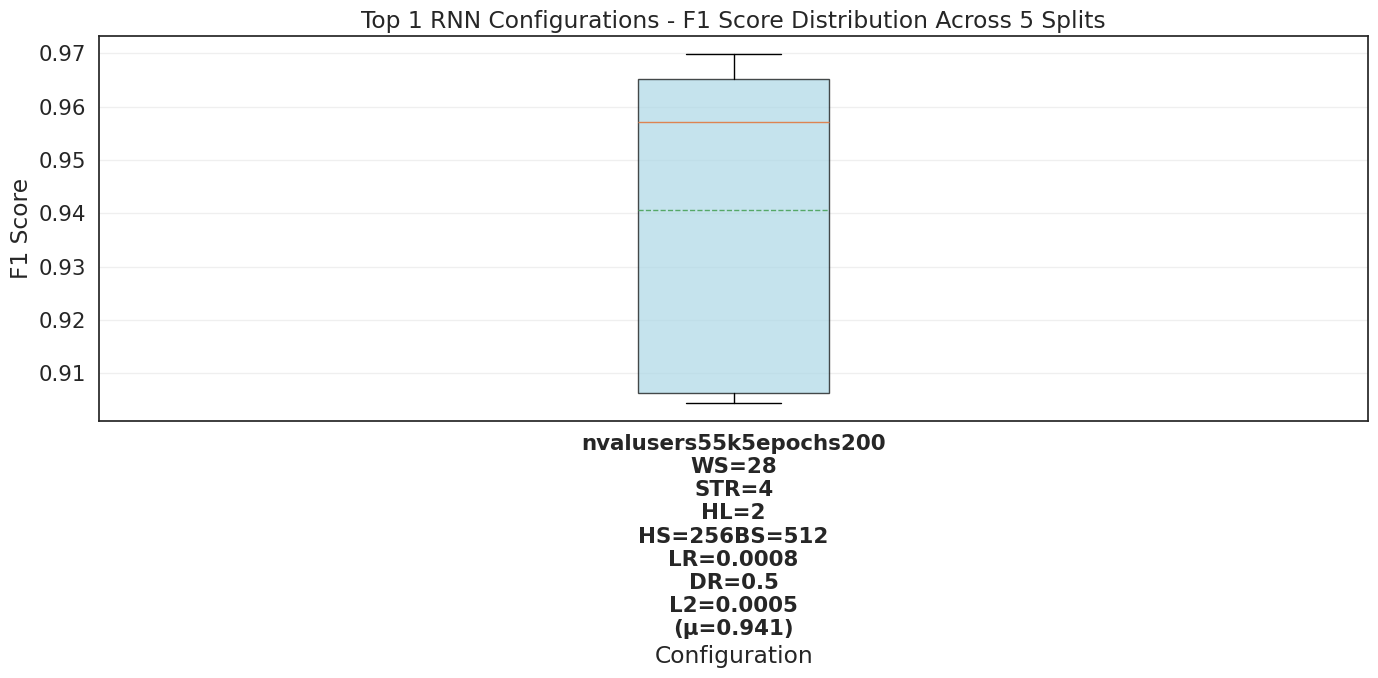

In [20]:
plot_top_configurations_rnn(results, k_splits=param_grid['k'][0], top_n=5)

In [21]:
# ============================================
# 1. CV SUMMARY: Mean, Std, 95% CI, Lower Bound
# ============================================

from scipy import stats

print("="*80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*80)

# Compute statistics for each configuration
config_stats = []
k = param_grid['k'][0]

for config_name, fold_scores in results.items():
   # Extract individual fold scores
   split_scores = [fold_scores[f'split_{i}'] for i in range(k) if f'split_{i}' in fold_scores]
   
   mean_f1 = fold_scores['mean']
   std_f1 = fold_scores['std']
   
   # 95% Confidence Interval (t-distribution)
   # For k=5: df=4, t_critical ≈ 2.776
   t_critical = stats.t.ppf(0.975, k-1)
   margin_error = t_critical * (std_f1 / np.sqrt(k))
   ci_lower = mean_f1 - margin_error
   ci_upper = mean_f1 + margin_error
   
   # Conservative estimate: mean - std
   conservative_estimate = mean_f1 - std_f1
   
   config_stats.append({
      'config': config_name,
      'mean': mean_f1,
      'std': std_f1,
      'ci_lower': ci_lower,
      'ci_upper': ci_upper,
      'conservative': conservative_estimate,
      'cv_score': f"{mean_f1:.4f}±{std_f1:.4f}"
   })

# Sort by mean F1 (descending)
config_stats.sort(key=lambda x: x['mean'], reverse=True)

# Create DataFrame for better visualization
stats_df = pd.DataFrame(config_stats)

print(f"\nTop 10 Configurations (sorted by mean F1):\n")
print(f"{'Rank':<5} {'Mean F1':<9} {'Std':<8} {'95% CI':<20} {'Conservative':<13} {'Config'}")
print("-"*80)

for idx, row in stats_df.head(10).iterrows():
   rank = idx + 1
   ci_str = f"[{row['ci_lower']:.4f}, {row['ci_upper']:.4f}]"
   # Shorten config name for display
   short_config = row['config'][:50] + "..." if len(row['config']) > 50 else row['config']
   
   print(f"{rank:<5} {row['mean']:.4f}    {row['std']:.4f}   {ci_str:<20} {row['conservative']:.4f}        {short_config}")

# Highlight best configuration
best_row = stats_df.iloc[0]
print("\n" + "="*80)
print("BEST CONFIGURATION DETAILS:")
print("="*80)
print(f"Configuration: {best_row['config']}")
print(f"Mean F1:       {best_row['mean']:.4f}")
print(f"Std Dev:       {best_row['std']:.4f}")
print(f"95% CI:        [{best_row['ci_lower']:.4f}, {best_row['ci_upper']:.4f}]")
print(f"Conservative:  {best_row['conservative']:.4f}")
print(f"\n📊 Expected Test F1 Range:")
print(f"  - Optimistic:    {best_row['ci_upper']:.4f}")
print(f"  - Realistic:     {best_row['mean']:.4f}")
print(f"  - Conservative:  {best_row['conservative']:.4f}")
print(f"  - Lower Bound:   {best_row['ci_lower']:.4f}")
print("="*80)

CROSS-VALIDATION RESULTS SUMMARY

Top 10 Configurations (sorted by mean F1):

Rank  Mean F1   Std      95% CI               Conservative  Config
--------------------------------------------------------------------------------
1     0.9406    0.0291   [0.9045, 0.9767]     0.9115        n_val_users_55_k_5_epochs_200_window_size_28_strid...

BEST CONFIGURATION DETAILS:
Configuration: n_val_users_55_k_5_epochs_200_window_size_28_stride_4_hidden_layers_2_hidden_size_256_batch_size_512_learning_rate_0.0008_dropout_rate_0.5_l2_lambda_0.0005
Mean F1:       0.9406
Std Dev:       0.0291
95% CI:        [0.9045, 0.9767]
Conservative:  0.9115

📊 Expected Test F1 Range:
  - Optimistic:    0.9767
  - Realistic:     0.9406
  - Conservative:  0.9115
  - Lower Bound:   0.9045


# Prediction

In [22]:
# ========================================
# STEP 1: PREPARE FINAL TRAINING
# ========================================
print("="*60)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*60)

# Merge best config with fixed params
final_best_params = {**fixed_params, **best_config}
print("\nBest Configuration Found:")
for key, value in final_best_params.items():
   print(f"  {key}: {value}")
print(f"\nBest CV F1 Score: {best_score:.4f}")

# ========================================
# STEP 2: CREATE FINAL TRAIN/VAL SPLIT
# (Use minimal validation set, maximize training data)
# ========================================
print("\n" + "="*60)
print("CREATING FINAL TRAIN/VAL SPLIT")
print("="*60)

# Use MINIMAL validation set (e.g., 10% of n_val_users from grid search)
# This maximizes training data while keeping a small val set for early stopping
unique_samples = X_train['sample_index'].unique()
random.seed(SEED)
np.random.seed(SEED)
np.random.shuffle(unique_samples)

# Use smaller validation set than CV (e.g., 20-30 samples instead of 45)
n_val_users_final = max(20, int(final_best_params['n_val_users']))  # Half of CV val size
n_train_samples = len(unique_samples) - n_val_users_final

train_samples = unique_samples[:n_train_samples]
val_samples = unique_samples[n_train_samples:]

df_train_final = X_train[X_train['sample_index'].isin(train_samples)].copy()
df_val_final = X_train[X_train['sample_index'].isin(val_samples)].copy()

print(f"Training samples: {len(train_samples)} ({df_train_final.shape[0]} timesteps)")
print(f"Validation samples: {len(val_samples)} ({df_val_final.shape[0]} timesteps)")
print(f"Training data: {len(train_samples)/(len(train_samples)+len(val_samples))*100:.1f}% of total")

# ========================================
# STEP 3: PREPROCESS DATA
# ========================================
# Map labels (if needed)
if df_train_final['label'].dtype == 'object':
   df_train_final['label'] = df_train_final['label'].map(pain_mapping)
   df_val_final['label'] = df_val_final['label'].map(pain_mapping)

# Define columns to normalize (all columns except sample_index, time, and label)
exclude_columns = ['sample_index', 'time', 'label']
scale_columns = [col for col in df_train_final.columns if col not in exclude_columns]

# Build sequences
print("\nBuilding sequences...")
X_train_final, y_train_final = build_sequences(
   df_train_final, 
   window=final_best_params['window_size'], 
   stride=final_best_params['stride']
)
X_val_final, y_val_final = build_sequences(
   df_val_final, 
   window=final_best_params['window_size'], 
   stride=final_best_params['stride']
)

print(f"Training sequences: {X_train_final.shape}")
print(f"Validation sequences: {X_val_final.shape}")

# Calculate class weights for final training to handle imbalance
class_counts_final = np.bincount(y_train_final)
total_samples_final = len(y_train_final)
class_weights_final = total_samples_final / (num_classes * class_counts_final)
class_weights_tensor_final = torch.FloatTensor(class_weights_final).to(device)

print(f"\nClass distribution in final training set: {class_counts_final}")
print(f"Class weights: {class_weights_final}")

# Create PyTorch datasets
train_ds_final = TensorDataset(
   torch.from_numpy(X_train_final.astype(np.float32)), 
   torch.from_numpy(y_train_final.astype(np.int64))
)
val_ds_final = TensorDataset(
   torch.from_numpy(X_val_final.astype(np.float32)), 
   torch.from_numpy(y_val_final.astype(np.int64))
)

# Create data loaders
train_loader_final = make_loader(
   train_ds_final, 
   batch_size=final_best_params['batch_size'], 
   shuffle=True, 
   drop_last=False
)
val_loader_final = make_loader(
   val_ds_final, 
   batch_size=final_best_params['batch_size'], 
   shuffle=False, 
   drop_last=False
)

# ========================================
# STEP 4: INITIALIZE FINAL MODEL
# ========================================
print("\n" + "="*60)
print("INITIALIZING FINAL MODEL")
print("="*60)

final_model = RecurrentClassifier(
   input_size=X_train_final.shape[2],
   hidden_size=final_best_params['hidden_size'],
   num_layers=final_best_params['hidden_layers'],
   num_classes=num_classes,
   dropout_rate=final_best_params['dropout_rate'],
   bidirectional=final_best_params['bidirectional'],
   rnn_type=final_best_params['rnn_type']
).to(device)

recurrent_summary(final_model, input_size=(final_best_params['window_size'], X_train_final.shape[2]))

# ========================================
# STEP 5: TRAIN FINAL MODEL
# ========================================
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

optimizer_final = torch.optim.AdamW(
   final_model.parameters(), 
   lr=final_best_params['learning_rate'], 
   weight_decay=final_best_params['l2_lambda']
)
scaler_final = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Create directory for final model
os.makedirs("models/final_model", exist_ok=True)

# Create weighted loss function for final training
criterion_final = nn.CrossEntropyLoss(weight=class_weights_tensor_final)

# Train with MORE epochs than CV (since we have more data)
final_epochs = int(final_best_params['epochs'])  # 1.5x more epochs
final_patience = PATIENCE
print(f"Training for {final_epochs} epochs")

final_model, training_history = fit(
   model=final_model,
   train_loader=train_loader_final,
   val_loader=val_loader_final,
   epochs=final_epochs,
   criterion=criterion_final,  # Use weighted criterion
   optimizer=optimizer_final,
   scaler=scaler_final,
   device=device,
   l1_lambda=final_best_params['l1_lambda'],
   l2_lambda=0,  # Already in optimizer weight_decay
   patience=final_patience,
   evaluation_metric="val_f1",
   mode='max',
   restore_best_weights=True,
   writer=None,
   verbose=VERBOSE,
   experiment_name="final_model/best"
)

print(f"\n✓ Final model trained!")
print(f"Best Validation F1: {max(training_history['val_f1']):.4f}")
print(f"CV F1 Score: {best_score:.4f}")
print(f"Improvement: {max(training_history['val_f1']) - best_score:+.4f}")

# ========================================
# STEP 6: LOAD TEST DATA
# ========================================
print("\n" + "="*60)
print("PREPARING TEST DATA")
print("="*60)

X_test = pd.read_csv('out/preprocessed_test.csv')

df_test_original = X_test.copy()
df_test_processed = X_test.copy()

# Build test sequences
df_test_processed['label'] = 0  # Dummy label
X_test_sequences, _ = build_sequences(
   df_test_processed,
   window=final_best_params['window_size'],
   stride=final_best_params['stride']
)

print(f"Test sequences: {X_test_sequences.shape}")

# ========================================
# STEP 7: MAKE PREDICTIONS
# ========================================
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

# Load the best model weights
final_model.load_state_dict(torch.load("models/final_model/best_model.pt", map_location=device))
final_model.eval()

# Create test loader
test_ds = TensorDataset(torch.from_numpy(X_test_sequences.astype(np.float32)))
test_loader = DataLoader(
   test_ds,
   batch_size=final_best_params['batch_size'],
   shuffle=False,
   num_workers=2
)

# Get predictions
all_predictions = []
with torch.no_grad():
   for (xb,) in test_loader:
      xb = xb.to(device)
      logits = final_model(xb)
      preds = logits.argmax(dim=1).cpu().numpy()
      all_predictions.append(preds)

all_predictions = np.concatenate(all_predictions)
print(f"Total window predictions: {len(all_predictions)}")

# ========================================
# STEP 8: MAP PREDICTIONS TO SAMPLES  (coerente con build_sequences)
# ========================================
sample_predictions = []
pred_idx = 0

unique_samples = df_test_processed['sample_index'].unique()
window = final_best_params['window_size']
stride = final_best_params['stride']

def n_windows_like_training(n_timestamps: int, window: int, stride: int) -> int:
   """Conta le finestre esattamente come in build_sequences:
      - se L < window: 1 finestra (padding solo fino a window)
      - altrimenti sliding con stride
      - ancora l’ultima finestra alla fine se non già inclusa
   """
   L = n_timestamps
   if L <= 0:
      return 0
   if L < window:
      return 1

   starts = list(range(0, max(L - window, 0) + 1, stride))
   last_start = L - window
   if last_start >= 0 and (len(starts) == 0 or starts[-1] != last_start):
      starts.append(last_start)
   return len(starts)

print(f"\nMapping {len(all_predictions)} windows to {len(unique_samples)} samples...")

for sample_id in unique_samples:
   L = (df_test_processed['sample_index'] == sample_id).sum()
   n_windows = n_windows_like_training(L, window, stride)

   end_idx = min(pred_idx + n_windows, len(all_predictions))
   sample_window_predictions = all_predictions[pred_idx:end_idx]

   if sample_window_predictions.size > 0:
      final_prediction = np.bincount(sample_window_predictions).argmax()
   else:
      final_prediction = 0  # fallback prudente

   sample_predictions.append({
      'sample_index': sample_id,
      'predicted_label_id': final_prediction,
      'predicted_label': label_reverse_mapping[final_prediction]
   })

   pred_idx = end_idx

# Safety: it needs to consume all windows
assert pred_idx == len(all_predictions), \
    f"Consumed {pred_idx} preds but have {len(all_predictions)}"
# ========================================
# STEP 9: SAVE RESULTS
# ========================================
predictions_df = pd.DataFrame(sample_predictions)

output_df = df_test_original[['sample_index']].drop_duplicates().merge(
    predictions_df,
    on='sample_index',
    how='left'
)

# Handle missing predictions
if output_df['predicted_label'].isna().any():
    print(f"WARNING: {output_df['predicted_label'].isna().sum()} samples missing predictions")
    output_df['predicted_label'].fillna('no_pain', inplace=True)

# Save CSV
output_filename = 'pirate_pain_test_predictions.csv'
output_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print("\n" + "="*60)
print("PREDICTIONS SAVED")
print("="*60)
print(f"Output file: {output_filename}")
print(f"Total samples: {len(output_df)}")
print(f"\n📊 Performance Comparison:")
print(f"  CV Mean F1: {best_score:.4f}")
print(f"  Final Model Val F1: {max(training_history['val_f1']):.4f}")
print(f"  Improvement: {max(training_history['val_f1']) - best_score:+.4f} ({((max(training_history['val_f1'])/best_score - 1)*100):+.1f}%)")

print("\n📈 Prediction Distribution:")
print(output_df['predicted_label'].value_counts())
print("\nPercentages:")
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    count = (output_df['predicted_label'] == pain_level).sum()
    percentage = (count / len(output_df)) * 100
    print(f"  {pain_level}: {count} ({percentage:.1f}%)")

print("\n🔍 First 10 predictions:")
print(output_df.head(10))

TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS

Best Configuration Found:
  l1_lambda: 0
  rnn_type: GRU
  bidirectional: True
  n_val_users: 55
  k: 5
  epochs: 200
  window_size: 28
  stride: 4
  hidden_layers: 2
  hidden_size: 256
  batch_size: 512
  learning_rate: 0.0008
  dropout_rate: 0.5
  l2_lambda: 0.0005

Best CV F1 Score: 0.9406

CREATING FINAL TRAIN/VAL SPLIT
Training samples: 606 (96960 timesteps)
Validation samples: 55 (8800 timesteps)
Training data: 91.7% of total

Building sequences...
Built 20604 sequences with 20604 labels
Built 1870 sequences with 1870 labels
Training sequences: (20604, 28, 71)
Validation sequences: (1870, 28, 71)

Class distribution in final training set: [15810  3060  1734]
Class weights: [0.4344086  2.24444444 3.96078431]

INITIALIZING FINAL MODEL
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 28, 512], [4, -1,

PER-CLASS PERFORMANCE ANALYSIS

📋 Classification Report (Validation Set):

              precision    recall  f1-score   support

     no_pain     0.9846    0.9840    0.9843      1564
    low_pain     0.9921    0.9191    0.9542       136
   high_pain     0.8508    0.9059    0.8775       170

    accuracy                         0.9722      1870
   macro avg     0.9425    0.9363    0.9387      1870
weighted avg     0.9730    0.9722    0.9724      1870



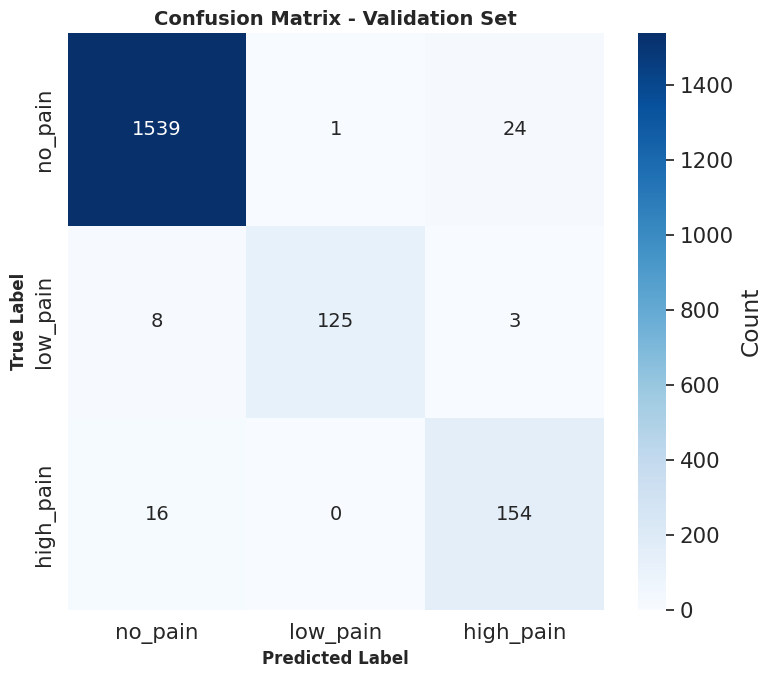


📊 Per-Class Analysis:

  no_pain:
    Support:   1564 samples (83.6%)
    Precision: 0.9846
    Recall:    0.9840
    F1 Score:  0.9843

  low_pain:
    Support:   136 samples (7.3%)
    Precision: 0.9921
    Recall:    0.9191
    F1 Score:  0.9542

  high_pain:
    Support:   170 samples (9.1%)
    Precision: 0.8508
    Recall:    0.9059
    F1 Score:  0.8775



In [23]:
# ============================================
# 3. PER-CLASS METRICS & CONFUSION MATRIX
# ============================================
# Evaluate the final model on validation set

from sklearn.metrics import classification_report, confusion_matrix

print("="*80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

if 'final_model' in globals() and 'val_loader_final' in globals():
   # Get predictions on validation set
   final_model.eval()
   all_val_preds = []
   all_val_targets = []
   
   with torch.no_grad():
      for inputs, targets in val_loader_final:
         inputs = inputs.to(device)
         logits = final_model(inputs)
         preds = logits.argmax(dim=1).cpu().numpy()
         all_val_preds.append(preds)
         all_val_targets.append(targets.numpy())
   
   y_true = np.concatenate(all_val_targets)
   y_pred = np.concatenate(all_val_preds)
   
   # Classification Report
   print("\n📋 Classification Report (Validation Set):\n")
   target_names = ['no_pain', 'low_pain', 'high_pain']
   report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
   print(report)
   
   # Confusion Matrix
   cm = confusion_matrix(y_true, y_pred)
   
   # Plot confusion matrix
   fig, ax = plt.subplots(figsize=(8, 7))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=target_names, 
               yticklabels=target_names,
               cbar_kws={'label': 'Count'},
               ax=ax)
   ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
   ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
   ax.set_title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
   plt.tight_layout()
   plt.show()
   
   # Compute per-class metrics
   print("\n📊 Per-Class Analysis:")
   for i, class_name in enumerate(target_names):
      # True Positives, False Positives, False Negatives
      tp = cm[i, i]
      fp = cm[:, i].sum() - tp
      fn = cm[i, :].sum() - tp
      tn = cm.sum() - tp - fp - fn
      
      precision = tp / (tp + fp) if (tp + fp) > 0 else 0
      recall = tp / (tp + fn) if (tp + fn) > 0 else 0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
      support = cm[i, :].sum()
      
      print(f"\n  {class_name}:")
      print(f"    Support:   {support} samples ({support/len(y_true)*100:.1f}%)")
      print(f"    Precision: {precision:.4f}")
      print(f"    Recall:    {recall:.4f}")
      print(f"    F1 Score:  {f1:.4f}")
      
      # Check for class imbalance issues
      if f1 < 0.7 and support > len(y_true) * 0.1:  # Low F1 for non-trivial class
         print(f"    ⚠️  LOW PERFORMANCE - Consider class balancing or more training data")
   
   print("\n" + "="*80)
else:
   print("⚠️  Final model or validation loader not available.")
   print("   Run the final model training cell first.")
   print("="*80)

In [24]:
# ============================================
# 4. OVERFITTING DIAGNOSTIC SUMMARY
# ============================================
# Consolidate all metrics and provide actionable recommendations

print("="*80)
print("OVERFITTING DIAGNOSTIC SUMMARY & RECOMMENDATIONS")
print("="*80)

# 1. CV Statistics Summary
if 'results' in globals() and 'best_config' in globals():
   # Build config string from best_config dict
   config_parts = []
   for key in sorted(best_config.keys()):
      config_parts.append(f"{key}_{best_config[key]}")
   config_str = "_".join(config_parts)
   
   # Find matching result entry
   matching_key = None
   for k in results.keys():
      if config_str in k or all(f"{key}_{best_config[key]}" in k for key in best_config.keys()):
         matching_key = k
         break
   
   if matching_key is None:
      print(f"⚠️  Could not find exact match for best_config in results.")
      print(f"   Looking for config containing: {config_str[:80]}...")
      # Use best_score entry from results
      if 'best_score' in globals() and results:
         # Find entry with mean closest to best_score
         best_match = None
         min_diff = float('inf')
         for k, v in results.items():
               if isinstance(v, dict) and 'mean' in v:
                  diff = abs(v['mean'] - best_score)
                  if diff < min_diff:
                     min_diff = diff
                     best_match = k
         if best_match:
               matching_key = best_match
               print(f"   Using closest match by mean F1: {matching_key[:80]}...")
   
   if matching_key:
      entry = results[matching_key]
      # Extract fold scores (split_0, split_1, ...)
      f1_scores = []
      for key in sorted(entry.keys()):
         if key.startswith('split_'):
               f1_scores.append(entry[key])
      
      if len(f1_scores) > 0:
         f1_scores = np.array(f1_scores)
         best_cv_mean = np.mean(f1_scores)
         best_cv_std = np.std(f1_scores, ddof=1)
         cv_variability = best_cv_std / best_cv_mean if best_cv_mean > 0 else 0

         print(f"\n1️⃣ Cross-Validation Stability:")
         print(f"   Best Config Mean F1:  {best_cv_mean:.4f} ± {best_cv_std:.4f}")
         print(f"   Coefficient of Var:   {cv_variability:.2%}")

         if cv_variability < 0.05:
               print("   ✅ STABLE - Low variance across folds (< 5%)")
         elif cv_variability < 0.10:
               print("   ⚠️  MODERATE - Some variance across folds (5-10%)")
         else:
               print("   ❌ UNSTABLE - High variance across folds (> 10%)")
               print("      → Consider: more training data, ensemble methods, or hyperparameter tuning")
      else:
         print("⚠️  No split scores found in results entry.")
   else:
      print("⚠️  Could not locate results entry. Skipping CV stability analysis.")
else:
   print("⚠️  'results' or 'best_config' not found. Skipping CV stability analysis.")

# 2. Learning Curves Summary
if 'training_history' in globals():
   # Check for correct keys (train_loss vs train_losses, etc.)
   loss_key = 'train_loss' if 'train_loss' in training_history else 'train_losses'
   val_loss_key = 'val_loss' if 'val_loss' in training_history else 'val_losses'
   f1_key = 'train_f1' if 'train_f1' in training_history else 'train_f1_scores'
   val_f1_key = 'val_f1' if 'val_f1' in training_history else 'val_f1_scores'

   if loss_key in training_history and val_loss_key in training_history:
      # Final epoch metrics
      final_train_loss = training_history[loss_key][-1]
      final_val_loss = training_history[val_loss_key][-1]
      final_train_f1 = training_history[f1_key][-1]
      final_val_f1 = training_history[val_f1_key][-1]

      # Best epoch metrics
      best_epoch_idx = int(np.argmax(training_history[val_f1_key]))
      best_val_f1 = training_history[val_f1_key][best_epoch_idx]
      best_train_f1 = training_history[f1_key][best_epoch_idx]

      # Compute gaps
      loss_gap = abs(final_train_loss - final_val_loss)
      loss_gap_pct = (loss_gap / final_val_loss * 100) if final_val_loss > 0 else 0
      f1_gap = abs(final_train_f1 - final_val_f1)
      f1_gap_pct = (f1_gap / final_val_f1 * 100) if final_val_f1 > 0 else 0

      print(f"\n2️⃣ Train-Validation Gap Analysis:")
      print(f"   Final Train Loss:  {final_train_loss:.4f}")
      print(f"   Final Val Loss:    {final_val_loss:.4f}")
      print(f"   Loss Gap:          {loss_gap:.4f} ({loss_gap_pct:.2f}%)")
      print(f"   Final Train F1:    {final_train_f1:.4f}")
      print(f"   Final Val F1:      {final_val_f1:.4f}")
      print(f"   F1 Gap:            {f1_gap:.4f} ({f1_gap_pct:.2f}%)")

      if f1_gap_pct < 3:
         overfitting_status = "✅ MINIMAL OVERFITTING"
         overfitting_action = "Model generalizes well. Proceed with confidence."
      elif f1_gap_pct < 8:
         overfitting_status = "⚠️  MODERATE OVERFITTING"
         overfitting_action = "Consider: higher dropout, more L2 regularization, or data augmentation."
      else:
         overfitting_status = "❌ SIGNIFICANT OVERFITTING"
         overfitting_action = "Action needed: increase dropout and L2, or get more data."

      print(f"\n   {overfitting_status} ({f1_gap_pct:.2f}% gap)")
      print(f"   → {overfitting_action}")
   else:
      print("\n⚠️  training_history keys don't match expected format. Skipping learning curve analysis.")
else:
   print("\n⚠️  'training_history' not found. Skipping learning curve analysis.")

# 3. Expected Test Performance
if 'f1_scores' in locals() and len(f1_scores) > 0:
   # Conservative estimates
   conservative_f1 = best_cv_mean - best_cv_std

   # Confidence interval (95%)
   from scipy.stats import t
   n_folds = len(f1_scores)
   try:
      t_critical = t.ppf(0.975, n_folds - 1)
      margin_error = t_critical * (best_cv_std / np.sqrt(n_folds))
      ci_lower = best_cv_mean - margin_error
      ci_upper = best_cv_mean + margin_error
   except Exception:
      ci_lower, ci_upper = best_cv_mean - best_cv_std, best_cv_mean + best_cv_std

   print(f"\n3️⃣ Expected Test Set Performance:")
   print(f"   Optimistic:        {best_cv_mean:.4f} (CV mean)")
   print(f"   Realistic:         {ci_lower:.4f} - {ci_upper:.4f} (95% CI)")
   print(f"   Conservative:      {conservative_f1:.4f} (mean - 1 std)")
   print(f"   Lower Bound:       {np.min(f1_scores):.4f} (worst fold)")

   print(f"\n   🎯 EXPECTED TEST F1: {ci_lower:.4f} to {best_cv_mean:.4f}")
   print(f"      (Use conservative estimate {conservative_f1:.4f} for planning)")

# 4. Final Recommendations
print(f"\n4️⃣ Next Steps:")
print("   " + "─"*70)

recommendations = []

# Based on CV stability
if 'f1_scores' in locals() and 'cv_variability' in locals():
    if cv_variability >= 0.10:
        recommendations.append("🔄 High fold variance detected")

# Based on overfitting
if 'f1_gap_pct' in locals():
    if f1_gap_pct >= 8:
        recommendations.append("🛡️  Significant overfitting")
    elif f1_gap_pct >= 3:
        recommendations.append("⚖️  Moderate overfitting")

# Based on per-class performance
if 'final_model' in globals() and 'val_loader_final' in globals():
    recommendations.append("🔍 Review per-class metrics above - consider class balancing if any class < 0.7 F1")

# General next action
if len(recommendations) == 0:
    recommendations.append("✅ Model looks good - run the new 18-config grid search!")
else:
    recommendations.append("⏭️  Address issues above, then run the new 18-config grid search")

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print("\n" + "="*80)

OVERFITTING DIAGNOSTIC SUMMARY & RECOMMENDATIONS

1️⃣ Cross-Validation Stability:
   Best Config Mean F1:  0.9406 ± 0.0325
   Coefficient of Var:   3.46%
   ✅ STABLE - Low variance across folds (< 5%)

2️⃣ Train-Validation Gap Analysis:
   Final Train Loss:  0.0296
   Final Val Loss:    0.7022
   Loss Gap:          0.6726 (95.78%)
   Final Train F1:    0.9871
   Final Val F1:      0.9459
   F1 Gap:            0.0413 (4.36%)

   ⚠️  MODERATE OVERFITTING (4.36% gap)
   → Consider: higher dropout, more L2 regularization, or data augmentation.

3️⃣ Expected Test Set Performance:
   Optimistic:        0.9406 (CV mean)
   Realistic:         0.9002 - 0.9809 (95% CI)
   Conservative:      0.9081 (mean - 1 std)
   Lower Bound:       0.9044 (worst fold)

   🎯 EXPECTED TEST F1: 0.9002 to 0.9406
      (Use conservative estimate 0.9081 for planning)

4️⃣ Next Steps:
   ──────────────────────────────────────────────────────────────────────
   1. ⚖️  Moderate overfitting
   2. 🔍 Review per-class metr

LEARNING CURVES - Detecting Overfitting


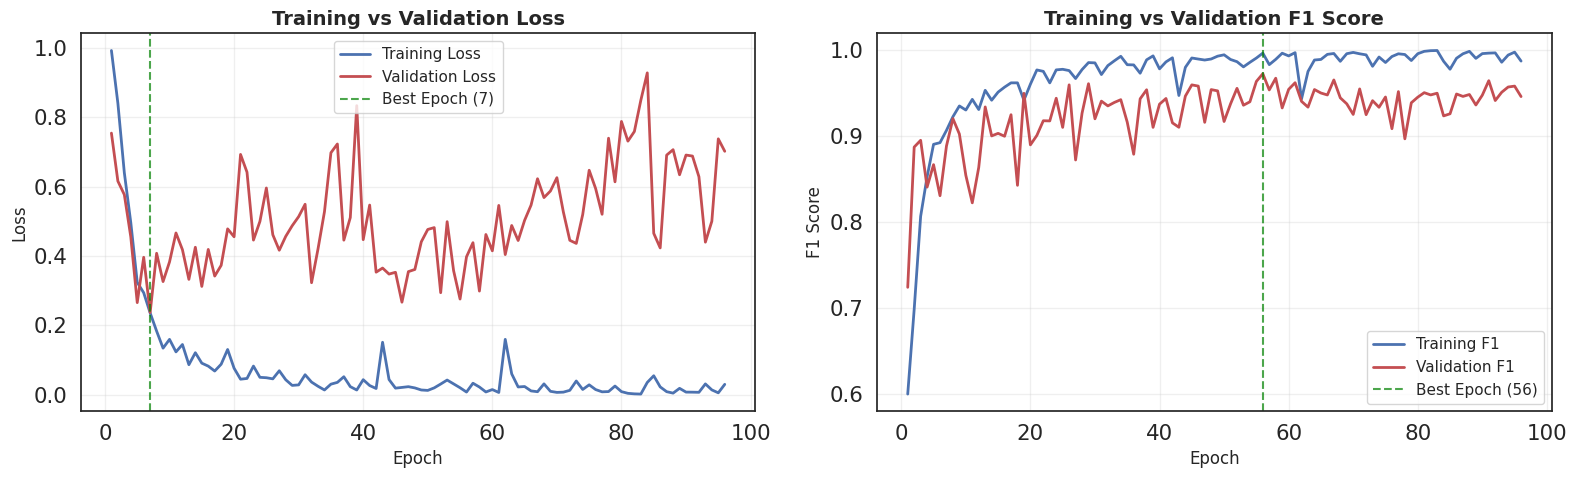


📊 Overfitting Analysis:
  Final Epoch:
    Train Loss: 0.0296  |  Val Loss: 0.7022
    Train F1:   0.9871  |  Val F1:   0.9459
    Loss Gap:   0.6726 (+2269.9%)
    F1 Gap:     0.0413 (+4.4%)

  At Best Val F1 Epoch:
    Train F1:   0.9964
    Val F1:     0.9724
    F1 Gap:     0.0240

🔍 Overfitting Diagnosis:
  ✅ MINIMAL OVERFITTING (gap: 2.5%)
     Model generalizes well. Test performance should be close to val performance.


In [25]:
# ============================================
# 2. LEARNING CURVES: Train vs Val (Loss & F1)
# ============================================
# Note: Uses training_history from the FINAL model training
# To see curves from CV, you'd need to modify k_shuffle_split to return histories

print("="*80)
print("LEARNING CURVES - Detecting Overfitting")
print("="*80)

if 'training_history' in globals() and training_history:
   fig, axes = plt.subplots(1, 2, figsize=(16, 5))
   
   # Plot 1: Loss curves
   epochs_range = range(1, len(training_history['train_loss']) + 1)
   axes[0].plot(epochs_range, training_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
   axes[0].plot(epochs_range, training_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
   axes[0].set_xlabel('Epoch', fontsize=12)
   axes[0].set_ylabel('Loss', fontsize=12)
   axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
   axes[0].legend(fontsize=11)
   axes[0].grid(alpha=0.3)
   
   # Highlight best epoch if early stopping was used
   if len(training_history['val_loss']) < int(final_best_params['epochs'] * 1.5):
      best_epoch_idx = np.argmin(training_history['val_loss'])
      axes[0].axvline(x=best_epoch_idx + 1, color='green', linestyle='--', 
                     label=f'Best Epoch ({best_epoch_idx + 1})', alpha=0.7)
      axes[0].legend(fontsize=11)
   
   # Plot 2: F1 Score curves
   axes[1].plot(epochs_range, training_history['train_f1'], 'b-', label='Training F1', linewidth=2)
   axes[1].plot(epochs_range, training_history['val_f1'], 'r-', label='Validation F1', linewidth=2)
   axes[1].set_xlabel('Epoch', fontsize=12)
   axes[1].set_ylabel('F1 Score', fontsize=12)
   axes[1].set_title('Training vs Validation F1 Score', fontsize=14, fontweight='bold')
   axes[1].legend(fontsize=11)
   axes[1].grid(alpha=0.3)
   
   # Highlight best epoch for F1
   best_f1_epoch_idx = np.argmax(training_history['val_f1'])
   axes[1].axvline(x=best_f1_epoch_idx + 1, color='green', linestyle='--', 
                  label=f'Best Epoch ({best_f1_epoch_idx + 1})', alpha=0.7)
   axes[1].legend(fontsize=11)
   
   plt.tight_layout()
   plt.show()
   
   # Compute overfitting metrics
   final_train_loss = training_history['train_loss'][-1]
   final_val_loss = training_history['val_loss'][-1]
   final_train_f1 = training_history['train_f1'][-1]
   final_val_f1 = training_history['val_f1'][-1]
   
   best_val_f1 = max(training_history['val_f1'])
   best_train_f1_at_best_val = training_history['train_f1'][np.argmax(training_history['val_f1'])]
   
   print(f"\n📊 Overfitting Analysis:")
   print(f"  Final Epoch:")
   print(f"    Train Loss: {final_train_loss:.4f}  |  Val Loss: {final_val_loss:.4f}")
   print(f"    Train F1:   {final_train_f1:.4f}  |  Val F1:   {final_val_f1:.4f}")
   print(f"    Loss Gap:   {(final_val_loss - final_train_loss):.4f} ({((final_val_loss/final_train_loss - 1)*100):+.1f}%)")
   print(f"    F1 Gap:     {(final_train_f1 - final_val_f1):.4f} ({((final_train_f1 - final_val_f1)/final_val_f1*100):+.1f}%)")
   
   print(f"\n  At Best Val F1 Epoch:")
   print(f"    Train F1:   {best_train_f1_at_best_val:.4f}")
   print(f"    Val F1:     {best_val_f1:.4f}")
   print(f"    F1 Gap:     {(best_train_f1_at_best_val - best_val_f1):.4f}")
   
   # Overfitting diagnosis
   f1_gap_pct = ((best_train_f1_at_best_val - best_val_f1) / best_val_f1) * 100
   
   print(f"\n🔍 Overfitting Diagnosis:")
   if f1_gap_pct < 3:
      print(f"  ✅ MINIMAL OVERFITTING (gap: {f1_gap_pct:.1f}%)")
      print(f"     Model generalizes well. Test performance should be close to val performance.")
   elif f1_gap_pct < 8:
      print(f"  ⚠️  MODERATE OVERFITTING (gap: {f1_gap_pct:.1f}%)")
      print(f"     Some overfitting present. Expect slight drop on test set.")
   else:
      print(f"  🚨 SIGNIFICANT OVERFITTING (gap: {f1_gap_pct:.1f}%)")
      print(f"     High risk! Consider: more regularization, less model complexity, more data.")
   
   print("="*80)
else:
   print("⚠️  No training_history available. Run final model training first.")
   print("="*80)